In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.legend_handler import HandlerBase

from sklearn.decomposition import PCA
from scipy.interpolate import interp1d

import os
import re

import h5py
from tqdm import tqdm

from utils import *
import mdaux
colors = mdaux.getValToColorMap([-1, 0, 1, 2, 3, 4])

In [2]:
# # this will load the data from the hdf5 file and format it as a pandas dataframe
# # the hdf5 files need to be in the current directory (same as the notebook)
# # ONLY RUN THIS CELL ONCE TO GET THE CSV FILES

# for dirname, _, filenames in os.walk('./'):
#     for filename in filenames:
#         path = os.path.join(dirname, filename)
#         if '.hdf5' in filename:
#             print(f'loading {path}')
#             df = load_and_format_data_as_df(path)
#             df.to_csv(f"./{filename.replace('.hdf5', '.csv')}", index=False)
#             print(f'saved under {filename.replace(".hdf5", ".csv")}')

In [3]:
df_A = pd.read_csv('A_nodes.csv', index_col=0)
df_B = pd.read_csv('B_nodes.csv', index_col=0)
df_C = pd.read_csv('C_nodes.csv', index_col=0)

In [4]:
# data encompasses "flock formation, circling, and landing" over a 30 minute period
# ~1800 chimney swift birds
# there are regions reported where the birds are highly correlated - when flying - and less correlated - when landing - as the intention of the study

In [5]:
# range of time in minutes
(df_A.time.max() - df_A.time.min()) / 60, (df_B.time.max() - df_B.time.min()) / 60, (df_C.time.max() - df_C.time.min()) / 60

(8.505727950172396, 9.431653876098322, 8.19263708152597)

In [6]:
# individual time ranges for tracks
# A
df_A.groupby('tid').apply(lambda x: x.time.max() - x.time.min()).describe()

count    24966.000000
mean         7.405351
std          6.848828
min          0.934268
25%          2.535869
50%          5.071738
75%         10.010010
max        100.066733
dtype: float64

In [7]:
# individual time ranges for tracks
# B
df_B.groupby('tid').apply(lambda x: x.time.max() - x.time.min()).describe()

count    78498.000000
mean         6.520097
std          5.619826
min          0.934268
25%          2.435769
50%          4.671338
75%          8.842176
max         59.092426
dtype: float64

In [8]:
# individual time ranges for tracks
# C
df_C.groupby('tid').apply(lambda x: x.time.max() - x.time.min()).describe()

count    39403.000000
mean         4.478242
std          3.859843
min          0.934268
25%          1.968635
50%          3.169837
75%          5.472139
max         42.442442
dtype: float64

In [9]:
# velocity order parameter
vel_order_A = get_velocity_order_parameter(df_A)
vel_order_B = get_velocity_order_parameter(df_B)
vel_order_C = get_velocity_order_parameter(df_C)

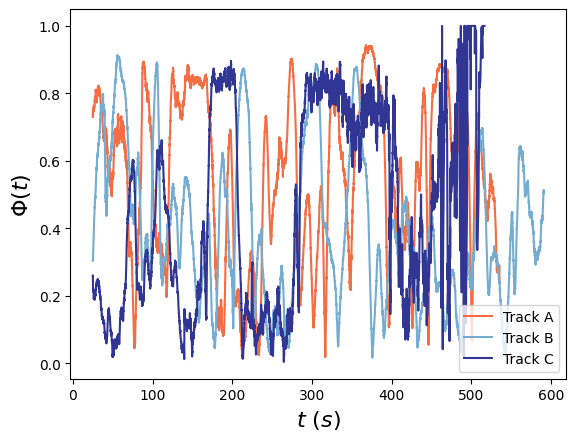

In [10]:
plt.plot(np.sort(df_A.time.unique()), vel_order_A, label='Track A', color=colors[0])
plt.plot(np.sort(df_B.time.unique()), vel_order_B, label='Track B', color=colors[3])
plt.plot(np.sort(df_C.time.unique()), vel_order_C, label='Track C', color=colors[4])
plt.legend()
plt.xlabel('$t$ ($s$)', fontsize=16)
plt.ylabel('$\Phi(t)$', fontsize=16)
plt.savefig('velocity_order_parameter.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
vars_A = get_variance_ratios(df_A)
vars_B = get_variance_ratios(df_B)
vars_C = get_variance_ratios(df_C)

100%|██████████| 4881/4881 [00:11<00:00, 423.84it/s]


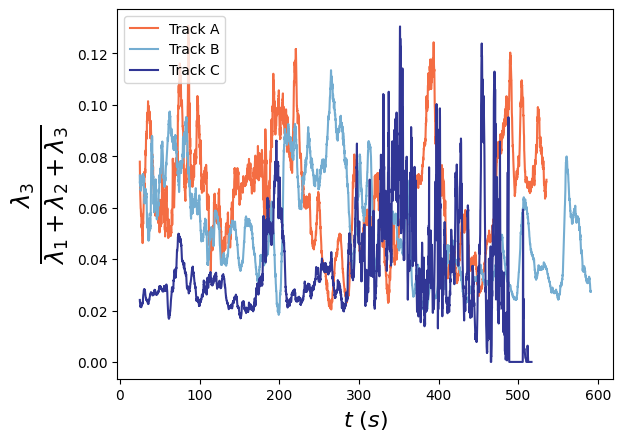

In [12]:
plt.plot(np.linspace(df_A.time.min(), df_A.time.max(), len(vars_A)), vars_A[:, 2], label='Track A', color=colors[0])
plt.plot(np.linspace(df_B.time.min(), df_B.time.max(), len(vars_B)), vars_B[:, 2], label='Track B', color=colors[3])
plt.plot(np.linspace(df_C.time.min(), df_C.time.max(), len(vars_C)), vars_C[:, 2], label='Track C', color=colors[4])
plt.legend()
plt.xlabel('$t$ ($s$)', fontsize=16)
plt.ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.savefig('variance_ratios.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# get density
densities_A = get_number_densities(df_A)
densities_B = get_number_densities(df_B)
densities_C = get_number_densities(df_C)

 95%|█████████▌| 4639/4881 [00:11<00:00, 507.31it/s]/Users/mmccraw/dev/yale/courses/integrated-workshop/project/code/data/utils.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  densities.append(sub_df.tid.nunique() / volume)
100%|██████████| 4881/4881 [00:11<00:00, 411.36it/s]


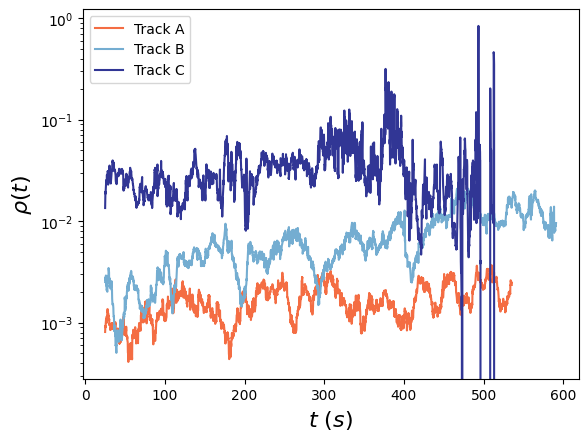

In [14]:
plt.plot(np.linspace(df_A.time.min(), df_A.time.max(), len(densities_A)), densities_A, label='Track A', color=colors[0])
plt.plot(np.linspace(df_B.time.min(), df_B.time.max(), len(densities_B)), densities_B, label='Track B', color=colors[3])
plt.plot(np.linspace(df_C.time.min(), df_C.time.max(), len(densities_C[densities_C < 1e6])), densities_C[densities_C < 1e6], label='Track C', color=colors[4])
plt.yscale('log')
plt.legend()
plt.xlabel('$t$ ($s$)', fontsize=16)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.savefig('number_density.png', dpi=300, bbox_inches='tight')

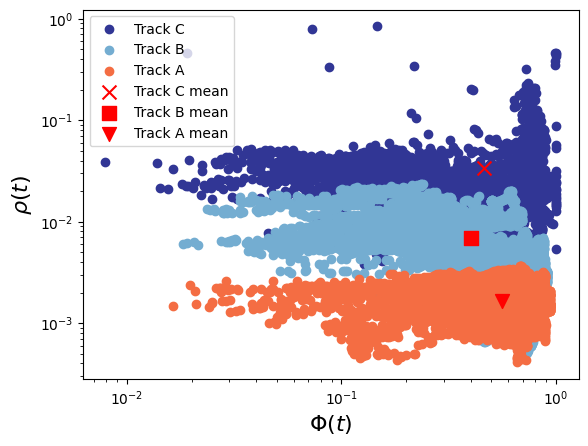

In [15]:
# correlation between velocity order parameter and density
plt.scatter(downsample_A2B(vel_order_C, densities_C[densities_C < 1e6]), densities_C[densities_C < 1e6], label='Track C', color=colors[4])
plt.scatter(downsample_A2B(vel_order_B, densities_B), densities_B, label='Track B', color=colors[3])
plt.scatter(downsample_A2B(vel_order_A, densities_A), densities_A, label='Track A', color=colors[0])
plt.scatter(np.mean(downsample_A2B(vel_order_C, densities_C[densities_C < 1e6])), np.mean(densities_C[densities_C < 1e6]), label='Track C mean', color='r', marker='x', s=100)
plt.scatter(np.mean(downsample_A2B(vel_order_B, densities_B)), np.mean(densities_B), label='Track B mean', color='r', marker='s', s=100)
plt.scatter(np.mean(downsample_A2B(vel_order_A, densities_A)), np.mean(densities_A), label='Track A mean', color='r', marker='v', s=100)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('$\Phi(t)$', fontsize=16)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.savefig('velocity_order_parameter_vs_density.png', dpi=300, bbox_inches='tight')

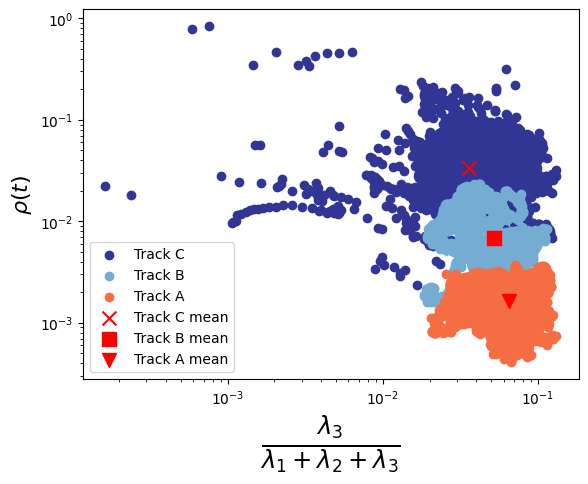

In [16]:
# correlation between velocity order parameter and density
plt.scatter(vars_C[:, 2][densities_C < 1e6], densities_C[densities_C < 1e6], label='Track C', color=colors[4])
plt.scatter(vars_B[:, 2], densities_B, label='Track B', color=colors[3])
plt.scatter(vars_A[:, 2], densities_A, label='Track A', color=colors[0])
plt.scatter(np.mean(vars_C[:, 2][densities_C < 1e6]), np.mean(densities_C[densities_C < 1e6]), label='Track C mean', color='r', marker='x', s=100)
plt.scatter(np.mean(vars_B[:, 2]), np.mean(densities_B), label='Track B mean', color='r', marker='s', s=100)
plt.scatter(np.mean(vars_A[:, 2]), np.mean(densities_A), label='Track A mean', color='r', marker='v', s=100)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.savefig('variance_ratios_vs_density.png', dpi=300, bbox_inches='tight')

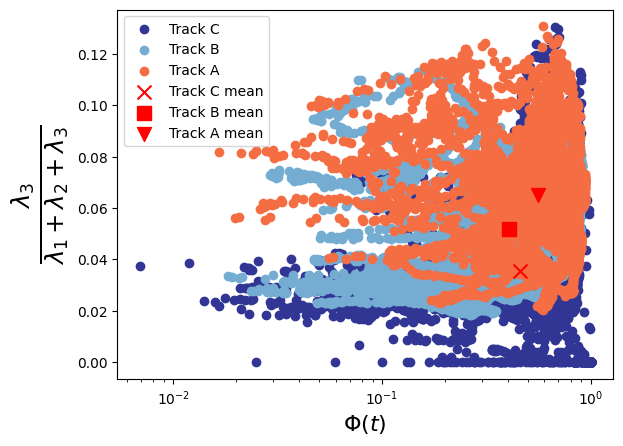

In [17]:
plt.scatter(downsample_A2B(vel_order_C, vars_C[:, 2]), vars_C[:, 2], label='Track C', color=colors[4])
plt.scatter(downsample_A2B(vel_order_B, vars_B[:, 2]), vars_B[:, 2], label='Track B', color=colors[3])
plt.scatter(downsample_A2B(vel_order_A, vars_A[:, 2]), vars_A[:, 2], label='Track A', color=colors[0])
plt.scatter(np.mean(downsample_A2B(vel_order_C, vars_C[:, 2])), np.mean(vars_C[:, 2]), label='Track C mean', color='r', marker='x', s=100)
plt.scatter(np.mean(downsample_A2B(vel_order_B, vars_B[:, 2])), np.mean(vars_B[:, 2]), label='Track B mean', color='r', marker='s', s=100)
plt.scatter(np.mean(downsample_A2B(vel_order_A, vars_A[:, 2])), np.mean(vars_A[:, 2]), label='Track A mean', color='r', marker='v', s=100)
plt.xscale('log')
plt.legend()
plt.xlabel('$\Phi(t)$', fontsize=16)
plt.ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.savefig('velocity_order_parameter_vs_variance_ratios.png', dpi=300, bbox_inches='tight')

100%|██████████| 1373/1373 [00:03<00:00, 452.53it/s]


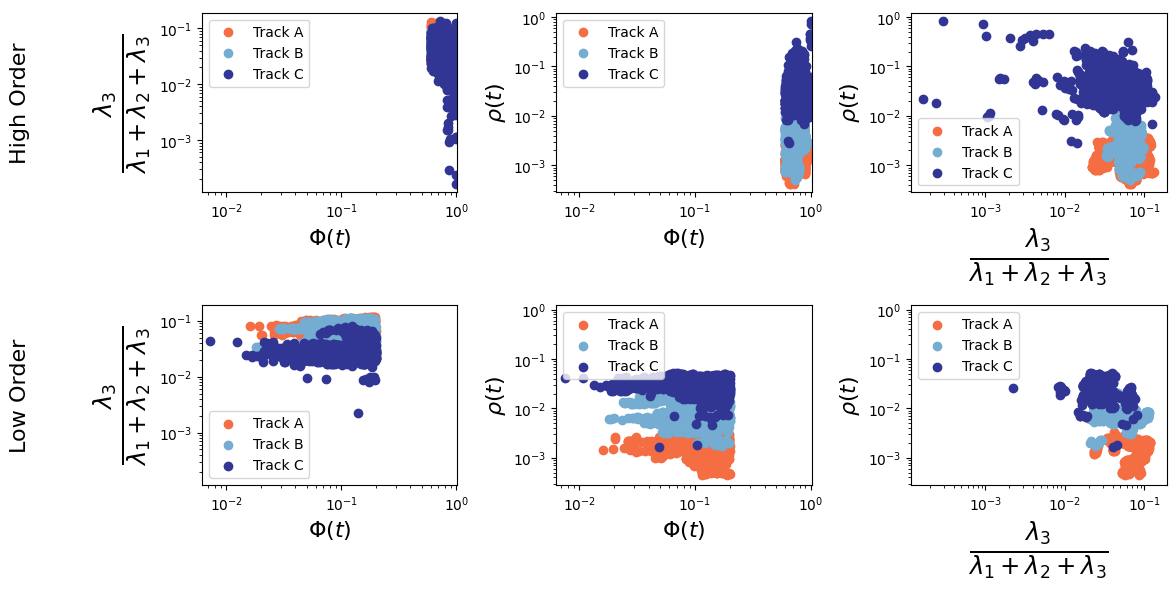

In [18]:
# is there common behavior in the high ordered regime and low ordered regime?
phi_high = 0.6
phi_low = 0.2

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

labels = ['Track A', 'Track B', 'Track C']
dfs = [df_A, df_B, df_C]
vel_orders = [vel_order_A, vel_order_B, vel_order_C]
cs = [colors[0], colors[3], colors[4]]

for i, (df, vel_order, label, color) in enumerate(zip(dfs, vel_orders, labels, cs)):
    df_sub = df[df.time.isin(vel_order[vel_order > phi_high].index.values)].copy()
    # vel = get_velocity_order_parameter(df_sub)
    vel = vel_order[vel_order > phi_high]
    var = get_variance_ratios(df_sub)
    dens = get_number_densities(df_sub)
    if df_sub.shape[0] > 0:
        axs[0, 0].scatter(downsample_A2B(vel, var[:, 2][var[:, 2] > 1e-9]), var[:, 2][var[:, 2] > 1e-9], label=label, color=color)
        axs[0, 1].scatter(downsample_A2B(vel, dens[dens < 1e6]), dens[dens < 1e6], label=label, color=color)
        axs[0, 2].scatter(var[:, 2][dens < 1e6], dens[dens < 1e6], label=label, color=color)

for i, (df, vel_order, label, color) in enumerate(zip(dfs, vel_orders, labels, cs)):
    df_sub = df[df.time.isin(vel_order[vel_order < phi_low].index.values)].copy()
    # vel = get_velocity_order_parameter(df_sub)
    vel = vel_order[vel_order < phi_low]
    var = get_variance_ratios(df_sub)
    dens = get_number_densities(df_sub)
    if df_sub.shape[0] > 0:
        axs[1, 0].scatter(downsample_A2B(vel, var[:, 2][var[:, 2] > 1e-9]), var[:, 2][var[:, 2] > 1e-9], label=label, color=color)
        axs[1, 1].scatter(downsample_A2B(vel, dens[dens < 1e6]), dens[dens < 1e6], label=label, color=color)
        axs[1, 2].scatter(var[:, 2][dens < 1e6], dens[dens < 1e6], label=label, color=color)

for i, _ in enumerate(axs):
    axs[i, 0].set_xlabel('$\Phi(t)$', fontsize=16)
    axs[i, 0].set_ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
    axs[i, 1].set_xlabel('$\Phi(t)$', fontsize=16)
    axs[i, 1].set_ylabel(r'$\rho(t)$', fontsize=16)
    axs[i, 2].set_xlabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
    axs[i, 2].set_ylabel(r'$\rho(t)$', fontsize=16)
    for j, ax in enumerate(_):
        ax.legend()
        # if j != 0:
        ax.set_yscale('log')
        ax.set_xscale('log')

for i, ax in enumerate(axs[0]):
    x_low = np.inf
    x_high = -np.inf
    y_low = np.inf
    y_high = -np.inf
    for j, _ in enumerate(axs):
        x_low = min(x_low, axs[j, i].get_xlim()[0])
        x_high = max(x_high, axs[j, i].get_xlim()[1])
        y_low = min(y_low, axs[j, i].get_ylim()[0])
        y_high = max(y_high, axs[j, i].get_ylim()[1])
    for j, _ in enumerate(axs):
        axs[j, i].set_xlim(x_low, x_high)
        axs[j, i].set_ylim(y_low, y_high)

label_offset = 0.75
axs[0, 0].text(-label_offset, 0.5, 'High Order', va='center', ha='left', rotation='vertical', transform=axs[0, 0].transAxes, fontsize=16)
axs[1, 0].text(-label_offset, 0.5, 'Low Order', va='center', ha='left', rotation='vertical', transform=axs[1, 0].transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('high_vs_low_order_correlations.png', dpi=300, bbox_inches='tight')

100%|██████████| 2484/2484 [00:03<00:00, 748.44it/s]


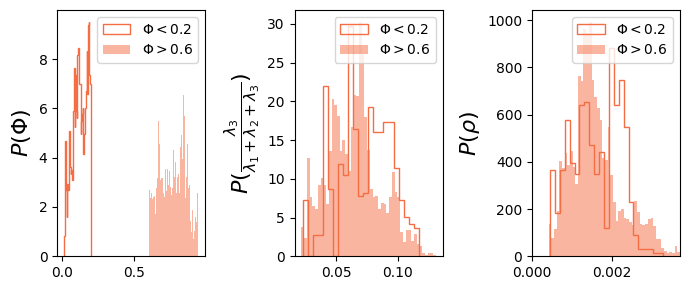

100%|██████████| 1183/1183 [00:02<00:00, 589.16it/s]


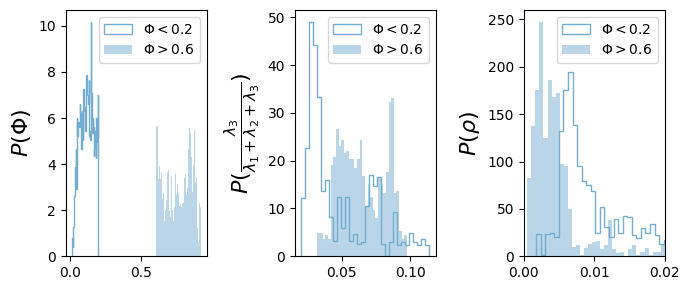

100%|██████████| 1901/1901 [00:00<00:00, 1916.59it/s]


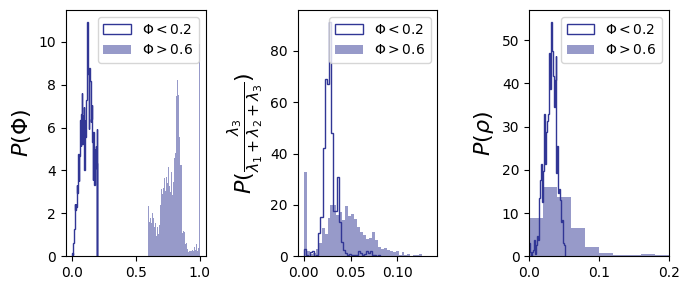

In [23]:
# vel_order_A[vel_order_A > phi_high].time
labels = ['Track A', 'Track B', 'Track C']
dfs = [df_A, df_B, df_C]
vel_orders = [vel_order_A, vel_order_B, vel_order_C]
cs = [colors[0], colors[3], colors[4]]

for i, (df, vel_order, label, color) in enumerate(zip(dfs, vel_orders, labels, cs)):
    fig, ax = plt.subplots(1, 3, figsize=(7, 3))
    for condition, cond_label in zip([vel_order > phi_high, vel_order < phi_low][::-1], [r'$\Phi>0.6$', r'$\Phi<0.2$'][::-1]):
        df_sub = df[df.time.isin(vel_order[condition].index.values)].copy()
        # vel = get_velocity_order_parameter(df_sub)
        vel = vel_order[condition]
        var = get_variance_ratios(df_sub)
        dens = get_number_densities(df_sub)
        plot_labels = [r'$P(\Phi)$', r'$P(\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3})$', r'$P(\rho)$']
        if vel.size > 0:
            for i, thing_to_plot in enumerate([vel, var[:, 2], dens[dens < 1e6]]):
                ax[i].set_ylabel(plot_labels[i], fontsize=16)
                if i == 2:
                    xmax = min(max(thing_to_plot), 0.2)
                    ax[i].set_xlim(0, xmax)
                if cond_label == r'$\Phi>0.6$':
                    ax[i].hist(thing_to_plot, bins=int(np.sqrt(thing_to_plot.size)), color=color, density=True, label=cond_label, alpha=0.5)
                else:
                    ax[i].hist(thing_to_plot, bins=int(np.sqrt(thing_to_plot.size)), color=color, density=True, histtype='step', label=cond_label)
    for _ in ax:
        _.legend()
    plt.tight_layout()
    plt.savefig(f'high_vs_low_order_correlations_PDF_{label}.png', dpi=300, bbox_inches='tight')
    plt.show()

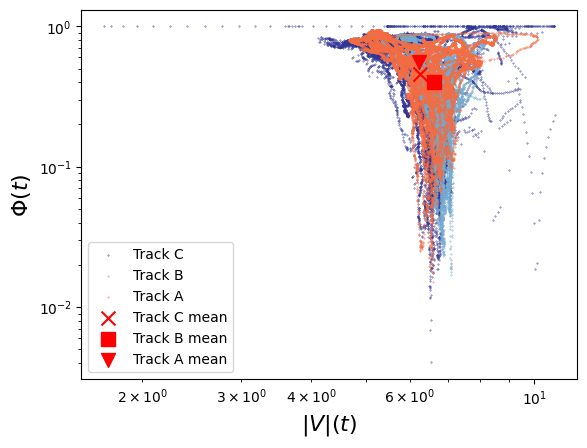

In [24]:
plt.scatter(df_C.groupby('time').V.mean(), vel_order_C, label='Track C', color=colors[4], s=0.1)
plt.scatter(df_B.groupby('time').V.mean(), vel_order_B, label='Track B', color=colors[3], s=0.1)
plt.scatter(df_A.groupby('time').V.mean(), vel_order_A, label='Track A', color=colors[0], s=0.1)
plt.scatter(np.mean(df_C.groupby('time').V.mean()), np.mean(vel_order_C), label='Track C mean', color='r', marker='x', s=100)
plt.scatter(np.mean(df_B.groupby('time').V.mean()), np.mean(vel_order_B), label='Track B mean', color='r', marker='s', s=100)
plt.scatter(np.mean(df_A.groupby('time').V.mean()), np.mean(vel_order_A), label='Track A mean', color='r', marker='v', s=100)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$|V|(t)$', fontsize=16)
plt.ylabel('$\Phi(t)$', fontsize=16)
plt.legend()
plt.savefig('velocity_order_parameter_vs_velocity_magnitude.png', dpi=300, bbox_inches='tight')

 95%|█████████▍| 4632/4881 [00:09<00:00, 532.97it/s]/Users/mmccraw/dev/yale/courses/integrated-workshop/project/code/data/utils.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  densities.append(sub_df.tid.nunique() / volume)
100%|██████████| 4881/4881 [00:09<00:00, 496.58it/s]


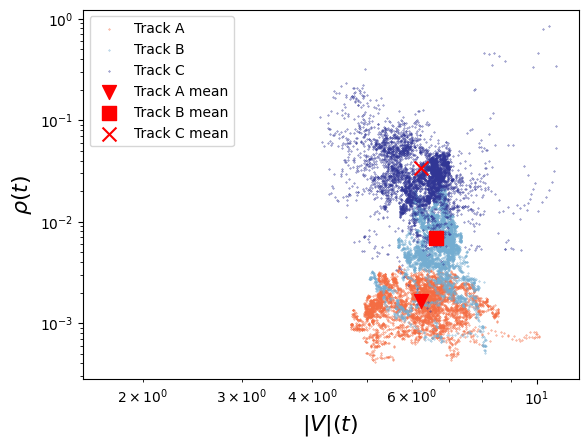

In [25]:
means = []
mags = []
for df, label, color in zip([df_A, df_B, df_C], ['Track A', 'Track B', 'Track C'], [colors[0], colors[3], colors[4]]):
    densities = get_number_densities(df)
    vel_mag = df.groupby('time').V.mean()
    vel_mag = downsample_A2B(vel_mag, densities[densities < 1e6])
    plt.scatter(vel_mag, densities[densities < 1e6], label=label, color=color, s=0.1)
    means.append(np.mean(densities[densities < 1e6]))
    mags.append(np.mean(vel_mag))
for df, label, mean, mag, marker in zip([df_A, df_B, df_C], ['Track A', 'Track B', 'Track C'], means, mags, ['v', 's', 'x']):
    plt.scatter(mag, mean, label=f'{label} mean', color='r', marker=marker, s=100)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$|V|(t)$', fontsize=16)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.legend()
plt.savefig('velocity_magnitude_vs_density.png', dpi=300, bbox_inches='tight')

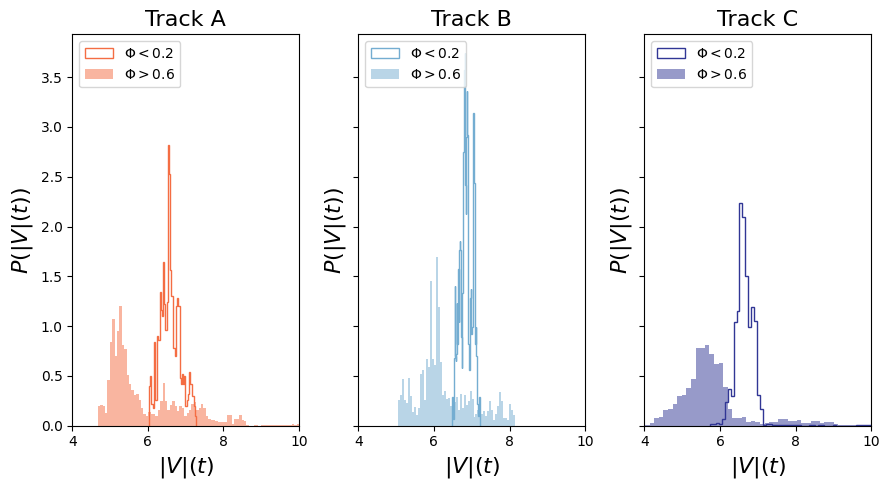

In [26]:
labels = ['Track A', 'Track B', 'Track C']
dfs = [df_A, df_B, df_C]
vel_orders = [vel_order_A, vel_order_B, vel_order_C]
cs = [colors[0], colors[3], colors[4]]

fig, ax = plt.subplots(1, 3, figsize=(9, 5), sharey=True, sharex=True)
ax[0].set_xlim(4, 10)
for i, (df, vel_order, label, color) in enumerate(zip(dfs, vel_orders, labels, cs)):
    for condition, cond_label in zip([vel_order > phi_high, vel_order < phi_low][::-1], [r'$\Phi>0.6$', r'$\Phi<0.2$'][::-1]):
        df_sub = df[df.time.isin(vel_order[condition].index.values)].copy()
        vel = vel_order[condition]
        vel_mag = df_sub.groupby('time').V.mean().values
        if vel.size > 0:
            if cond_label == r'$\Phi>0.6$':
                ax[i].hist(vel_mag, bins=int(np.sqrt(vel_mag.size)), color=color, density=True, label=cond_label, alpha=0.5)
            else:
                ax[i].hist(vel_mag, bins=int(np.sqrt(vel_mag.size)), color=color, density=True, histtype='step', label=cond_label)
    ax[i].legend(loc='upper left')
    ax[i].set_xlabel('$|V|(t)$', fontsize=16)
    ax[i].set_ylabel(r'$P(|V|(t))$', fontsize=16)
    ax[i].set_title(label, fontsize=16)
plt.tight_layout()
plt.savefig(f'high_vs_low_order_correlations_PDF_velocity_magnitude.png', dpi=300, bbox_inches='tight')

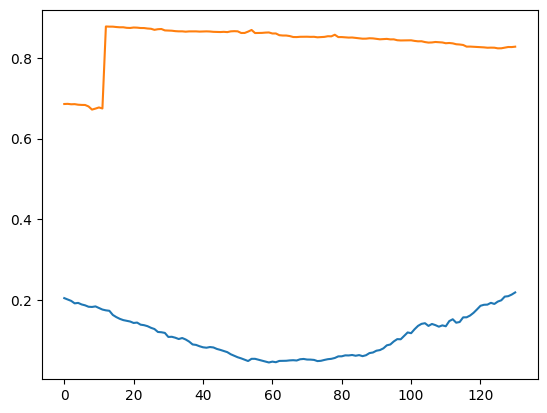

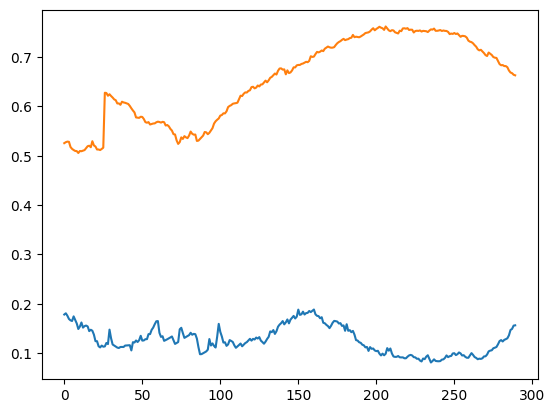

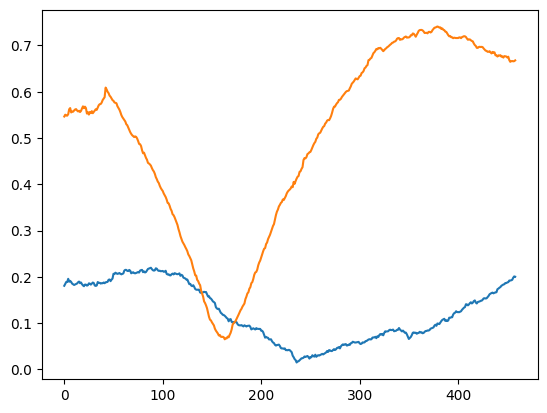

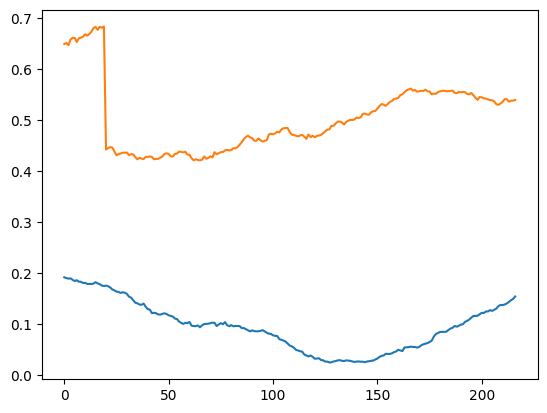

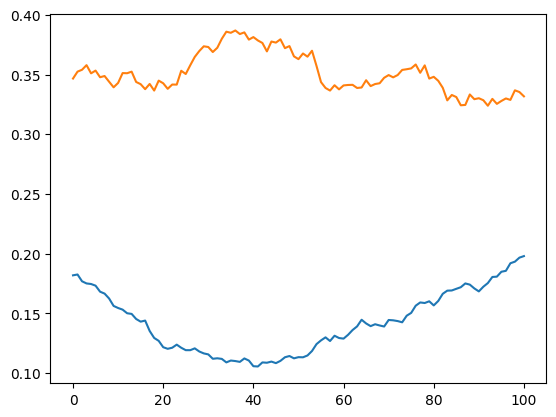

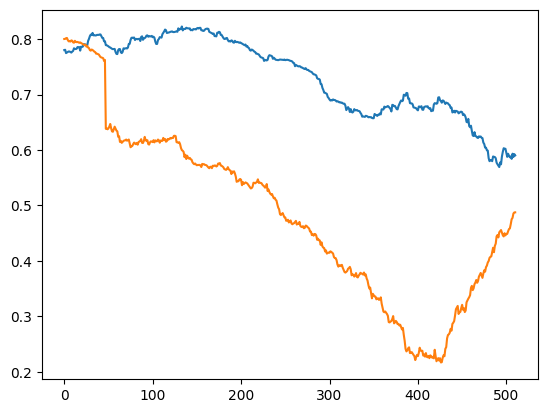

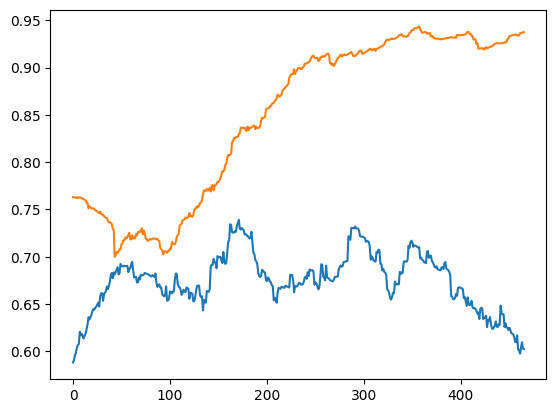

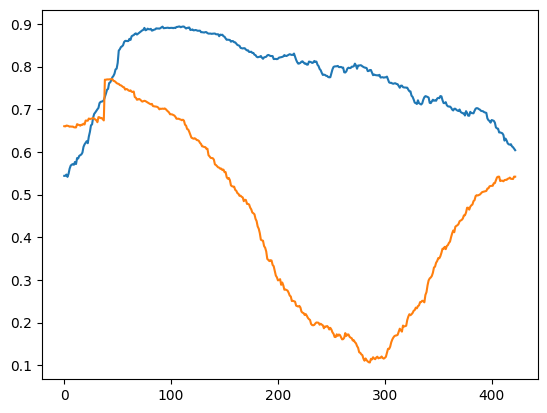

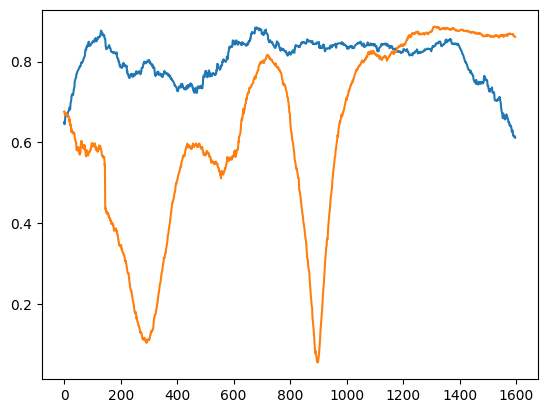

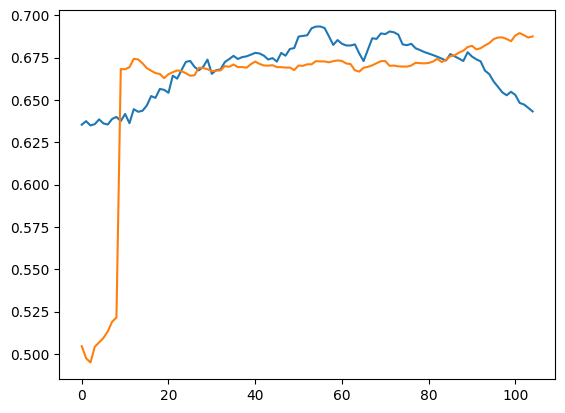

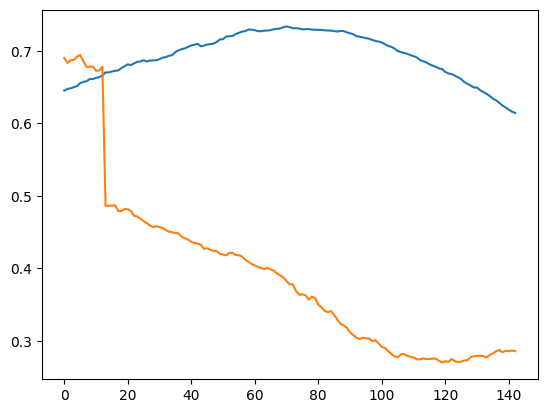

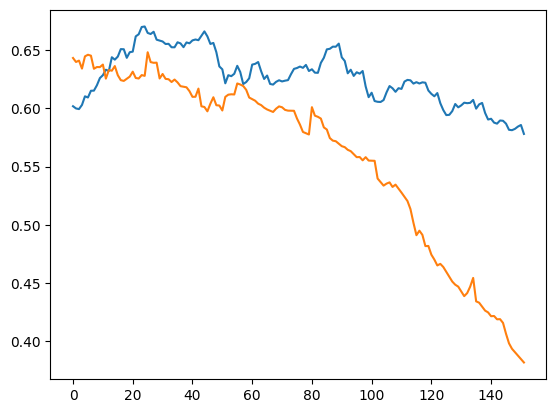

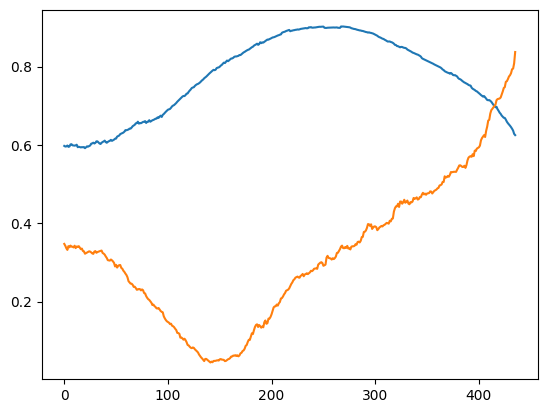

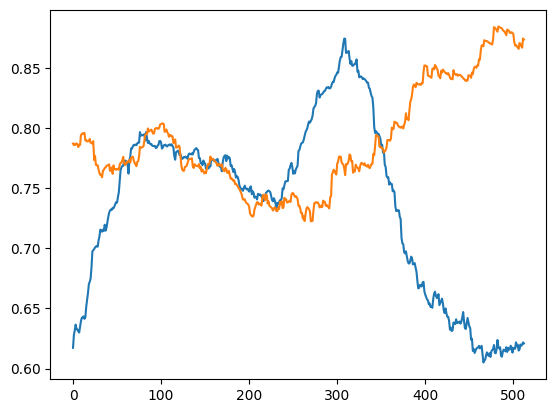

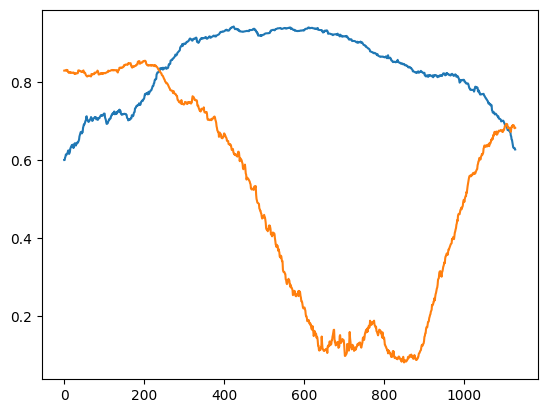

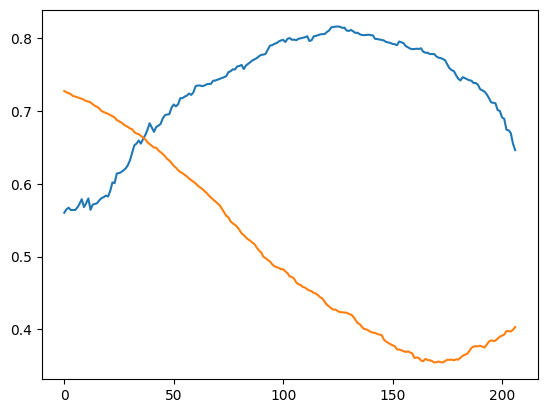

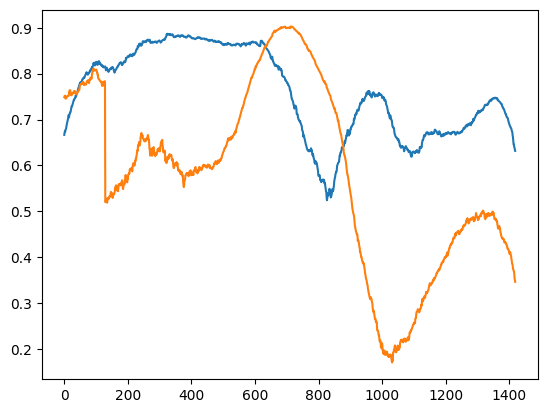

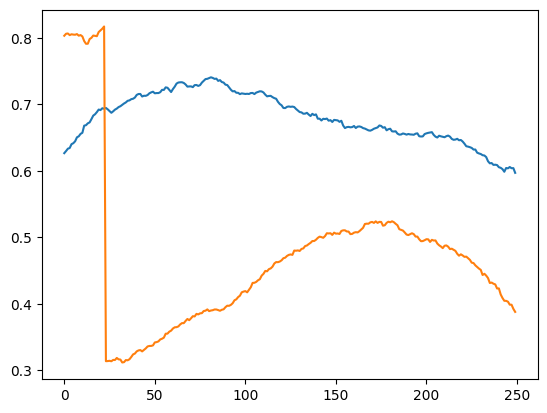

In [101]:
df_start = df_A
phi_low = 0.2
phi_high = 0.6
sm_perc = 0.01
min_length = 100

df = df_start.copy()
vel_order = get_velocity_order_parameter(df)
time = np.sort(df.time.unique())

win_size = int(vel_order.size * sm_perc)
vel_order_sm = np_convolve_moving_average(vel_order, win_size)

results = {'low': {'regimes': [], 'condition': vel_order_sm < phi_low}, 'high': {'regimes': [], 'condition': vel_order_sm > phi_high}}

for key in results.keys():
    condition = results[key]['condition']
    starts = np.where(np.diff(condition.astype(int)) == 1)[0] + 1
    stops = np.where(np.diff(condition.astype(int)) == -1)[0] + 1

    if condition[0]:
        starts = np.insert(starts, 0, 0)
    if condition[-1]:
        stops = np.append(stops, len(condition))

    offset = int(win_size / 2)
    adjusted_starts = starts + offset
    adjusted_stops = stops + offset

    adjusted_starts = np.clip(adjusted_starts, 0, len(vel_order) - 1)
    adjusted_stops = np.clip(adjusted_stops, 0, len(vel_order))

    for start, stop in zip(adjusted_starts, adjusted_stops):
        if stop - start > min_length:
            results[key]['regimes'].append(time[start:stop])
            sdf = df_start[df_start.time.isin(time[start:stop])]
            vel = get_velocity_order_parameter(sdf).values
            
            plt.plot(vel_order.values[start:stop])
            plt.plot(vel)
            plt.show()

In [103]:
time

array([ 33.36670003, 333.66700033, 333.70036703, ..., 333.56690023,
       333.60026693, 333.63363363])

In [39]:
# TODO: neighbor distribution function

# (split the data into ordered and disordered REGIMES i.e. continuous time periods where the order parameter is above or below a certain threshold)

low_regimes_A, high_regimes_A = section_df_into_disordered_ordered_regimes(df_A)
low_A_all = pd.concat([df_A[df_A.time.isin(low)] for low in low_regimes_A])
high_A_all = pd.concat([df_A[df_A.time.isin(high)] for high in high_regimes_A])
low_A_bin, low_A_pdf = get_dist_pdf(low_A_all)
high_A_bin, high_A_pdf = get_dist_pdf(high_A_all)

low_regimes_B, high_regimes_B = section_df_into_disordered_ordered_regimes(df_B)
low_B_all = pd.concat([df_B[df_B.time.isin(low)] for low in low_regimes_B])
high_B_all = pd.concat([df_B[df_B.time.isin(high)] for high in high_regimes_B])
low_B_bin, low_B_pdf = get_dist_pdf(low_B_all)
high_B_bin, high_B_pdf = get_dist_pdf(high_B_all)

low_regimes_C, high_regimes_C = section_df_into_disordered_ordered_regimes(df_C)
low_C_all = pd.concat([df_C[df_C.time.isin(low)] for low in low_regimes_C])
high_C_all = pd.concat([df_C[df_C.time.isin(high)] for high in high_regimes_C])
low_C_bin, low_C_pdf = get_dist_pdf(low_C_all)
high_C_bin, high_C_pdf = get_dist_pdf(high_C_all)

100%|██████████| 7352/7352 [00:20<00:00, 359.40it/s]


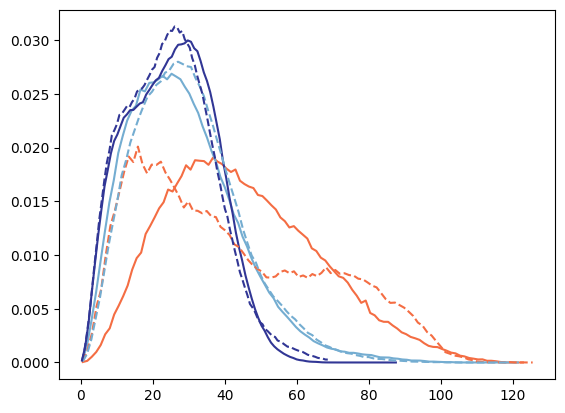

In [45]:
plt.plot(low_A_bin, low_A_pdf, label='Track A', color=colors[0])
plt.plot(low_B_bin, low_B_pdf, label='Track B', color=colors[3])
plt.plot(low_C_bin, low_C_pdf, label='Track C', color=colors[4])

plt.plot(high_A_bin, high_A_pdf, label='Track A', color=colors[0], linestyle='--')
plt.plot(high_B_bin, high_B_pdf, label='Track B', color=colors[3], linestyle='--')
plt.plot(high_C_bin, high_C_pdf, label='Track C', color=colors[4], linestyle='--')

In [50]:
order_all = pd.concat([high_A_all, high_B_all, high_C_all])
disorder_all = pd.concat([low_A_all, low_B_all, low_C_all])

density_order = get_number_densities(order_all)
density_disorder = get_number_densities(disorder_all)

variance_order = get_variance_ratios(order_all)
variance_disorder = get_variance_ratios(disorder_all)

vel_order = get_velocity_order_parameter(order_all)
vel_order = downsample_A2B(vel_order, density_order)

vel_disorder = get_velocity_order_parameter(disorder_all)
vel_disorder = downsample_A2B(vel_disorder, density_disorder)

 90%|████████▉ | 3853/4287 [00:10<00:01, 389.88it/s]/Users/mmccraw/dev/yale/courses/integrated-workshop/project/code/data/utils.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  densities.append(sub_df.tid.nunique() / volume)
100%|██████████| 2528/2528 [00:05<00:00, 495.59it/s]


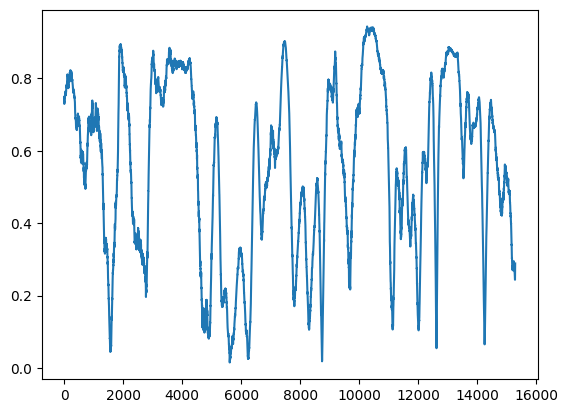

In [78]:
# plt.plot(get_velocity_order_parameter(df_A[df_A.time.isin(low_regimes_A[0])]).values)

plt.plot(get_velocity_order_parameter(df_A).values)

In [79]:
# plt.plot(vel_order_A)
# plt.plot(vel_order_B)
# plt.plot(vel_order_C)

# bin_centers, pdf_A = get_dist_pdf(df_A)

In [104]:
dists = np.array([])
for t in tqdm(df_A.time.unique()):
    df = df_A[df_A.time == t].copy()
    points = df[['x', 'y', 'z']].values
    diff = points[:, np.newaxis, :] - points[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=-1))
    distances = distances[np.triu_indices_from(distances, k=1)]
    dists = np.concatenate((dists, distances))

 10%|█         | 1555/15296 [00:35<05:14, 43.71it/s]


KeyboardInterrupt: 

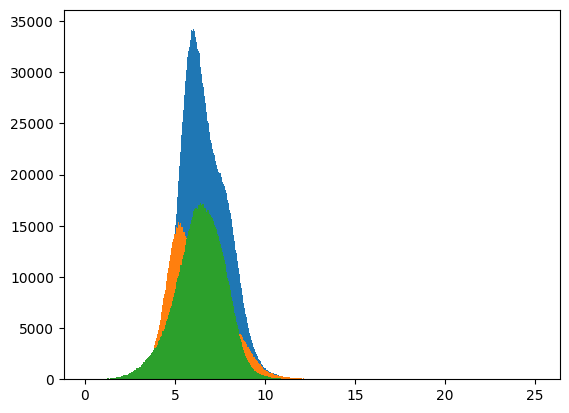

In [96]:
# TODO: comparison with maxwell boltzmann distribution

plt.hist(df_B.V, bins=int(np.sqrt(df_B.V.size)))
plt.hist(df_A.V, bins=int(np.sqrt(df_A.V.size)))
plt.hist(df_C.V, bins=int(np.sqrt(df_C.V.size)))
plt.show()

In [81]:
# better density calculation

dens_A_alt = get_number_densities_alt(df_A, skip_every_n_steps=3)
dens_B_alt = get_number_densities_alt(df_B, skip_every_n_steps=3)
dens_C_alt = get_number_densities_alt(df_C, skip_every_n_steps=3)

# these are very similar to the original density calculations, there is a slight underestimation of the density in the ordered regime, but it is systematic
# and thus shouldn't matter

In [ ]:
# TODO: time correlation function of the principal component directions

# (split the data into ordered and disordered REGIMES i.e. continuous time periods where the order parameter is above or below a certain threshold)

In [206]:


df = get_birds_in_time_range(df_A, time_start=40, time_end=42.5)
